# load model


In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" # select GPU
sys.path.append('/home/chenghao/Project/cav-mae')

# cav-mae 的整体模型定义并导入预训练权重

In [ ]:
import os
import torch
import timm
from src.models import CAVMAE

assert timm.__version__ == '0.4.5' # it is important to have right version of timm

model_path = 'pretrained_model/audio_model.pth'
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7" # select GPU
# CAV-MAE model with decoder
#print(torch.cuda.device_count())
torch.cuda.set_device(1)
audio_model = CAVMAE(audio_length=1024,
                     modality_specific_depth=11,
                     norm_pix_loss=True, tr_pos=False) # most models are trained with pixel normalization and non-trainabe positional embedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mdl_weight = torch.load(model_path, map_location=device)
audio_model = torch.nn.DataParallel(audio_model) # it is important to convert the model to dataparallel object as all weights are saved in dataparallel format (i.e., in module.xxx)
miss, unexpected = audio_model.load_state_dict(mdl_weight, strict=False)
print('miss=',miss, 'unexpected=', unexpected) # check if all weights are correctly loaded

# 定义my_cav-mae模型，查看其中的video模块输出维度

In [ ]:
import os
import torch
import timm
from src.models.my_model import MY_MODULE, MY_FT

pretrained_mae_path = 'pretrained_model/pretrained_maedfer.pth'
my_model = MY_FT(label_dim = 11, img_size=224, audio_length=1024, 
                       modality_specific_depth=11,
                       norm_pix_loss=True, tr_pos=False, pretrained_mae_path=pretrained_mae_path)


In [ ]:

Video_data = torch.randn(8, 3, 8, 224, 224)
Audio_data = torch.randn(8, 1024, 128)
output = my_model(Audio_data, Video_data,'multimodal')

In [ ]:
print(output)
print(output.shape)

# 定义mae dfer模型

In [55]:
#from src.models import modeling_finetune
import torch
from collections import OrderedDict
from src.models.modeling_finetune import vit_base_patch16_160, vit_base_dim512_no_depth_patch16_160

# 定义模型
model1 = vit_base_dim512_no_depth_patch16_160(num_classes=11)
model1 = model1.to('cuda')

# 加载预训练模型
pretrained_model = '/home/chenghao/Project/cav-mae/pretrained_model/pretrained_maedfer.pth'
checkpoint = torch.load(pretrained_model, map_location='cpu')

# 从预训练模型中获取权重
checkpoint_model = checkpoint['model']

# 删除不匹配的权重
state_dict = model1.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# 调整权重的键名
all_keys = list(checkpoint_model.keys())
new_dict = OrderedDict()
for key in all_keys:
    if key.startswith('backbone.'):
        new_dict[key[9:]] = checkpoint_model[key]
    elif key.startswith('encoder.'):
        new_dict[key[8:]] = checkpoint_model[key]
    else:
        new_dict[key] = checkpoint_model[key]

# 加载权重到模型
msg=model1.load_state_dict(new_dict, strict=False)

# 计算未正确导入权重的个数
total_keys = len(checkpoint['model'].keys())
num_unexpected_keys = len(msg.unexpected_keys)
num_missing_keys = len(msg.missing_keys)
model_total_keys = len(model1.state_dict().keys()) 

# 计算预训练模型中的权重数量
num_total_keys = len(checkpoint['model'].keys())



print(f'ckt total keys:{total_keys}')
print(f"Number of unexpected weights: {num_unexpected_keys}")

print(f"Number of model_total_keys: {model_total_keys}")
print(f"Number of missing weights: {num_missing_keys}")



ckt total keys:575
Number of unexpected weights: 501
Number of model_total_keys: 162
Number of missing weights: 88


# 用maedfer 进行一次前向

In [14]:

# 创建随机输入数据
input_data = torch.rand(8, 3, 16, 160, 160)

# 进行前向传播
input_data = input_data.to('cuda:0')
output1, output1_feature = model1(input_data,save_feature=True)
model1.reset_classifier( num_classes=10)
print(output1_feature.shape)
print(output1.shape)


torch.Size([8, 3, 16, 160, 160])
torch.Size([8, 3, 16, 160, 160])
torch.Size([8, 512])
torch.Size([8, 11])


In [ ]:
from src.models.modeling_pretrain import PretrainVisionTransformer
model2 = PretrainVisionTransformer()
input_data = torch.rand(8, 3, 16, 224, 224)
input_mask = torch.rand(8, 16, 160, 160)
output2, output2_feature = model2(input_data, input_mask)

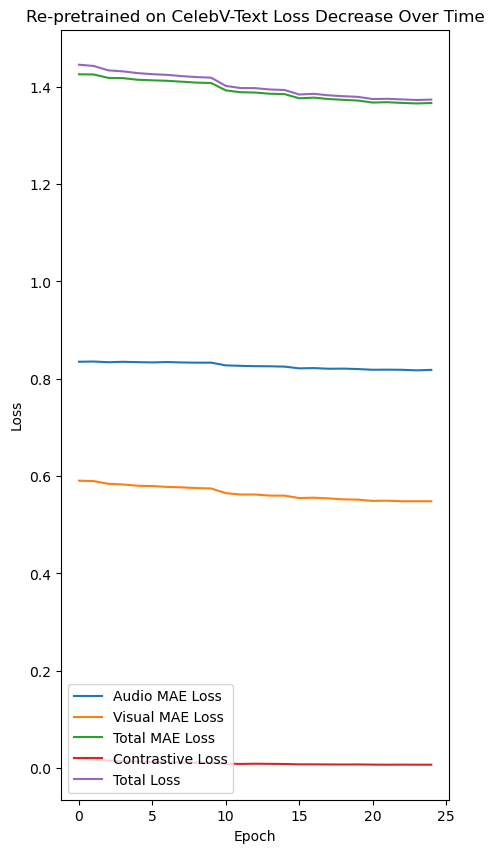

In [61]:
import re
import matplotlib.pyplot as plt

# 从日志文件中读取数据
log_dir = 'egs/celebv-text/exp/testmae01-audioset-cav-mae-balNone-lr1e-4-epoch25-bs40-normTrue-c0.01-p1.0-tpFalse-mr-unstructured-0.75-a5/log.txt'
log_dir_2 = '/home/chenghao/Project/cav-mae/egs/celebv-text/exp/testmae01-audioset-cav-mae-balNone-lr1e-4-epoch25-bs32-normTrue-c0.01-p1.0-tpFalse-mr-unstructured-0.75-a5/log.txt'

with open(log_dir, 'r') as f:
    log_data = f.read()

# 使用正则表达式匹配损失值
pattern_audio = r"Eval Audio MAE Loss: (\d+\.\d+)"
pattern_visual = r"Eval Visual MAE Loss: (\d+\.\d+)"
pattern_total_mae = r"Eval Total MAE Loss: (\d+\.\d+)"
pattern_contrastive = r"Eval Contrastive Loss: (\d+\.\d+)"
pattern_total = r"Eval Total Loss: (\d+\.\d+)"

loss_values_audio = re.findall(pattern_audio, log_data)
loss_values_visual = re.findall(pattern_visual, log_data)
loss_values_total_mae = re.findall(pattern_total_mae, log_data)
loss_values_contrastive = re.findall(pattern_contrastive, log_data)
loss_values_total = re.findall(pattern_total, log_data)

# 将损失值转换为浮点数
loss_values_audio = [float(value) for value in loss_values_audio]
loss_values_visual = [float(value) for value in loss_values_visual]
loss_values_total_mae = [float(value) for value in loss_values_total_mae]
loss_values_contrastive = [float(value) for value in loss_values_contrastive]
loss_values_total = [float(value) for value in loss_values_total]

# 创建一个新的figure，并设置其大小
plt.figure(figsize=(5,10))

# 绘制损失下降曲线
plt.plot(loss_values_audio, label='Audio MAE Loss')
plt.plot(loss_values_visual, label='Visual MAE Loss')
plt.plot(loss_values_total_mae, label='Total MAE Loss')
plt.plot(loss_values_contrastive, label='Contrastive Loss')
plt.plot(loss_values_total, label='Total Loss')
plt.title('Re-pretrained on CelebV-Text Loss Decrease Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import re
import matplotlib.pyplot as plt

# 从日志文件中读取数据
log_dir = 'egs/celebv-text/exp/testmae01-audioset-cav-mae-balNone-lr1e-4-epoch25-bs40-normTrue-c0.01-p1.0-tpFalse-mr-unstructured-0.75-a5/log.txt'
with open(log_dir, 'r') as f:
    log_data = f.read()

# 使用正则表达式匹配损失值
pattern_audio = r"Eval Audio MAE Loss: (\d+\.\d+)"
pattern_visual = r"Eval Visual MAE Loss: (\d+\.\d+)"
pattern_total_mae = r"Eval Total MAE Loss: (\d+\.\d+)"
pattern_contrastive = r"Eval Contrastive Loss: (\d+\.\d+)"
pattern_total = r"Eval Total Loss: (\d+\.\d+)"

loss_values_audio = re.findall(pattern_audio, log_data)
loss_values_visual = re.findall(pattern_visual, log_data)
loss_values_total_mae = re.findall(pattern_total_mae, log_data)
loss_values_contrastive = re.findall(pattern_contrastive, log_data)
loss_values_total = re.findall(pattern_total, log_data)

# 将损失值转换为浮点数
loss_values_audio = [float(value) for value in loss_values_audio]
loss_values_visual = [float(value) for value in loss_values_visual]
loss_values_total_mae = [float(value) for value in loss_values_total_mae]
loss_values_contrastive = [float(value) for value in loss_values_contrastive]
loss_values_total = [float(value) for value in loss_values_total]

# 创建一个新的figure，并设置其大小
plt.figure(figsize=(10, 5))

# 绘制损失下降曲线
plt.plot(loss_values_audio, label='Audio MAE Loss')
plt.plot(loss_values_visual, label='Visual MAE Loss')
plt.plot(loss_values_total_mae, label='Total MAE Loss')
plt.plot(loss_values_contrastive, label='Contrastive Loss')
plt.plot(loss_values_total, label='Total Loss')
plt.title('Loss Decrease Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import re
import matplotlib.pyplot as plt

# 从日志文件中读取数据
log_dir = 'egs/celebv-text/exp/testmae01-audioset-cav-mae-balNone-lr1e-4-epoch25-bs40-normTrue-c0.01-p1.0-tpFalse-mr-unstructured-0.75-a5/log.txt'
with open(log_dir, 'r') as f:
    log_data = f.read()

# 使用正则表达式匹配损失值
pattern_audio = r"Eval Audio MAE Loss: (\d+\.\d+)"
pattern_visual = r"Eval Visual MAE Loss: (\d+\.\d+)"
pattern_total_mae = r"Eval Total MAE Loss: (\d+\.\d+)"
pattern_contrastive = r"Eval Contrastive Loss: (\d+\.\d+)"
pattern_total = r"Eval Total Loss: (\d+\.\d+)"

loss_values_audio = re.findall(pattern_audio, log_data)
loss_values_visual = re.findall(pattern_visual, log_data)
loss_values_total_mae = re.findall(pattern_total_mae, log_data)
loss_values_contrastive = re.findall(pattern_contrastive, log_data)
loss_values_total = re.findall(pattern_total, log_data)

# 将损失值转换为浮点数
loss_values_audio = [float(value) for value in loss_values_audio]
loss_values_visual = [float(value) for value in loss_values_visual]
loss_values_total_mae = [float(value) for value in loss_values_total_mae]
loss_values_contrastive = [float(value) for value in loss_values_contrastive]
loss_values_total = [float(value) for value in loss_values_total]

# 创建一个新的figure，并设置其大小
plt.figure(figsize=(10, 5))

# 绘制损失下降曲线
plt.plot(loss_values_audio, label='Audio MAE Loss')
plt.plot(loss_values_visual, label='Visual MAE Loss')
plt.plot(loss_values_total_mae, label='Total MAE Loss')
plt.plot(loss_values_contrastive, label='Contrastive Loss')
plt.plot(loss_values_total, label='Total Loss')
plt.title('Loss Decrease Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()